This notebook aims to experiment the Gaussian process machine learning approach to price European Options

In [3]:
# Basic libraries
import pandas as pd
import numpy as np
import os
import sys
import random
import matplotlib.pyplot as plt

# Import machine learning libraries
from sklearn import gaussian_process
# We import Radial basis function kernel
from sklearn.gaussian_process.kernels import RBF

# Import libraries for from local scripts
chemin_dev = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if chemin_dev not in sys.path:
    sys.path.append(chemin_dev)
from options_pricing.scripts import black_scholes as bs
from options_pricing.scripts import data_processing as dp
from pprint import pprint

In [22]:
df_options = pd.read_csv('../../data/options/options_processed.csv')


In [23]:
df_options_c = df_options.loc[df_options['call_put'] == 'Call']
df_options_c.head()
df_options

,date,act_symbol,expiration,strike,call_put,bid,ask,vol,delta,gamma,theta,vega,rho,price,stock_price,time_to_maturity,interest_rate
0,2019-05-10,A,2019-05-17,65.0,Call,10.10,13.35,0.5636,0.9873,0.0055,-0.0185,0.0035,0.0122,11.725,76.64,0.019178,0.0242
2,2019-05-10,A,2019-05-17,70.0,Call,6.60,7.70,0.3212,0.9863,0.0102,-0.0133,0.0037,0.0132,7.150,76.64,0.019178,0.0242
4,2019-05-10,A,2019-05-17,72.5,Call,5.05,5.25,0.4973,0.8252,0.0486,-0.1018,0.0275,0.0112,5.150,76.64,0.019178,0.0242
6,2019-05-10,A,2019-05-17,75.0,Call,3.15,3.25,0.4644,0.6806,0.0721,-0.1300,0.0381,0.0094,3.200,76.64,0.019178,0.0242
8,2019-05-10,A,2019-05-17,77.5,Call,1.67,1.74,0.4410,0.4815,0.0847,-0.1365,0.0425,0.0068,1.705,76.64,0.019178,0.0242


In [42]:
params = {
    'name_run': 'gaussian_process_act_test',
    'type_batch': 'create_train_test_set_idx', # name of the function to create the batch of data
    'test_size' : 0.2, # proportion of test set
    'test_value' : 200, # if we choose no to train_test_split
    'number_time_repeat' : 5,
    'n_rows' : [100, 500, 1000, 2000, 3000],
    'features': ['strike', 'vol', 'delta', 'gamma', 'theta', 'vega', 'rho', 'time_to_maturity', 'interest_rate'], # features for the model  
    'gaussian_process': {
        'GaussianProcessRegressor': {
            'kernel': RBF(length_scale=1),
            'n_restarts_optimizer': 3,
            'alpha': 0.001,
            'random_state': 42, # here we keep it because we want to see differences with data and not with model initialization
        }
    }
}

In [48]:
def train_test_model(params):
    dicts_save = {}

    # We instanciate the GaussianProcessRegressor model with the parameters specified in the params dictionary
    gp =[getattr(gaussian_process, type_pro)(**params)for type_pro, params in params['gaussian_process'].items()][0]
    for test_value in params['n_rows']:
        dict_save = {}
        tab_metrics = np.zeros((params['number_time_repeat'], 4))
        tab_metrics_bs = np.zeros((params['number_time_repeat'], 4))
        for i in range(params['number_time_repeat']):
            X_train, X_test, y_train, y_test, scaler = dp.create_train_test_set_by_act_symbol(df_options_c, params['test_size'], test_value, params['features'])
            X_test_unscal = scaler.inverse_transform(X_test) # for bs model

            gp.fit(X_train, y_train)
            y_pred = gp.predict(X_test)
            mape, mae, mse, r2 = bs.compute_metrics(y_test, y_pred, params, test_value)
            tab_metrics[i] = [mape, mae, mse, r2]

            # for bs evaluation 
            X_test_df, y_test_df = dp.from_np_to_df(X_test_unscal, y_test, params['features'])
            df_price_bs, mape_bs, mae_bs, mse_bs, r2_bs = bs.evaluate_bs_options_pricing(y_test_df, X_test_df)
            tab_metrics_bs[i] = [mape_bs, mae_bs, mse_bs, r2_bs]

        mean_metrics = np.mean(tab_metrics, axis=0)
        std_metrics = np.std(tab_metrics, axis=0)
        mean_metrics_bs = np.mean(tab_metrics_bs, axis=0)
        std_metrics_bs = np.std(tab_metrics_bs, axis=0)
        dict_save[params['name_run']] = {
            'mean_metrics': mean_metrics,
            'std_metrics': std_metrics,
            'metrics': tab_metrics,
            'mean_metrics_bs': mean_metrics_bs,
            'std_metrics_bs': std_metrics_bs,
            'metrics_bs': tab_metrics_bs,
            'params': params
            }
        dicts_save[test_value] = dict_save
    return dicts_save

In [ ]:
dicts_test = train_test_model(params)

In [39]:
pprint(dicts_test)

{100: {'gaussian_process_act_test': {'mean_metrics': array([ 1.73088694,  1.86143797, 16.7602111 ,  0.5444938 ]),
                                     'mean_metrics_bs': array([0.27366607, 0.48211201, 0.54215544, 0.98296958]),
                                     'metrics': array([[ 1.17416292,  1.61003719,  8.51990005,  0.663661  ],
       [ 1.40383887,  2.47346629, 41.82990311,  0.61335631],
       [ 4.65717285,  1.48841878, 11.24184123,  0.88250553],
       [ 0.78664707,  3.10967444, 20.78455536, -0.32252568],
       [ 0.63261301,  0.62559313,  1.42485575,  0.88547181]]),
                                     'metrics_bs': array([[0.2276811 , 0.52510673, 0.6443884 , 0.97456156],
       [0.5042057 , 0.61064257, 0.69244957, 0.99359952],
       [0.18751317, 0.53741315, 0.66273717, 0.99307338],
       [0.31647715, 0.57532702, 0.64357767, 0.95904902],
       [0.13245323, 0.1620706 , 0.06762439, 0.99456443]]),
                                     'params': {'features': ['strike',
         

In [ ]:
for key, value in dicts_test.items():
    print(f"Test value: {key}")
    print('res for gp: ', value[params['name_run']]['mean_metrics'])
    print('res for bs: ', value[params['name_run']]['mean_metrics_bs'])
pprint(dicts_test)

## Données générées par BS

In [1]:
r = 0.0002  
S= 100
K = 130
sigma = 0.4 
T = 2.0     

In [54]:
# Lower bound and upper bound for the stock price generation
lb = 0.001           
ub = 300             

training_number = 10 
testing_number = 100 


# Generate the training and testing data 
train_x_1 = np.linspace(0, 1, training_number).astype('float32').reshape(training_number, 1)
train_y_1 = [bs.bs_options_pricing(lb + (ub - lb) * S, K, r, T, sigma)[0] for S in train_x_1]

test_x_1 = np.linspace(0, 1, testing_number).astype('float32').reshape(testing_number, 1)
test_y_1 = [bs.bs_options_pricing(lb + (ub - lb) * S, K, r, T, sigma)[0] for S in test_x_1]


In [55]:
sk_kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-05, 1000.0))
gp = gaussian_process.GaussianProcessRegressor(kernel=sk_kernel, n_restarts_optimizer=20)
gp.fit(train_x_1, train_y_1) # We train the model 

/Users/ambroisethibault/Documents/Cours/TX/dev/venv_tx/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


GaussianProcessRegressor(kernel=RBF(length_scale=1), n_restarts_optimizer=20)

In [56]:
y_pred_1, sigma_1 = gp.predict(test_x_1, return_std=True)
mape, mae, mse, r2 = bs.compute_metrics(test_y_1, y_pred_1)

MAPE:  38275986.86015128
MAE:  0.43795866673259437
MSE:  0.6488689698568444
R2:  0.9997890058329256
-----------------------------------




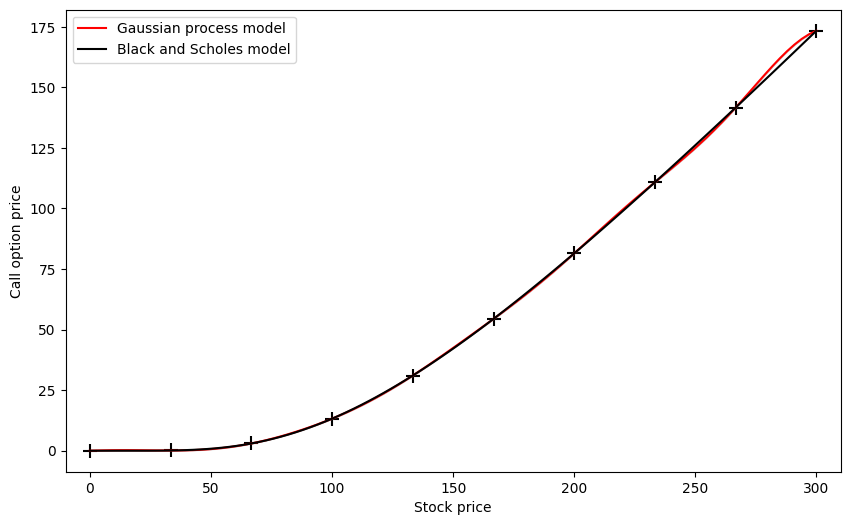

In [57]:
plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.plot(lb+(ub-lb)*test_x_1.flatten(), y_pred_1, color = 'red', label = 'Gaussian process model')
plt.plot(lb+(ub-lb)*test_x_1.flatten(), test_y_1, color = 'black', label = 'Black and Scholes model')
plt.scatter(lb+(ub-lb)*train_x_1, train_y_1, color = 'black', marker = '+', s = 100) 
plt.fill_between(lb+(ub-lb)*test_x_1.flatten(), (y_pred_1.T-2*sigma_1).flatten(), (y_pred_1.T+2*sigma_1).flatten(), color = 'grey', alpha=0.3)
plt.legend(loc = 'best', prop={'size':10})
plt.xlim([lb-10, ub+10])
plt.xlabel('Stock price')
plt.ylabel('Call option price');